# L3-C - Linear Quantization II: Per Channel Quantization

In this lesson, you will continue to learn about different granularities of performing linear quantization. You will cover `per channel` in this notebook.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Linear Quantization II` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch

from helper import get_q_scale_symmetric, linear_q_with_scale_and_zero_point, linear_dequantization
from helper import plot_quantization_errors, quantization_error

## Different Granularities for Quantization
- For simplicity, you'll perform these using Symmetric mode.

### Per Channel
- Implement `Per Channel` Symmetric Quantization
- `dim` parameter decides if it needs to be along the rows or columns

In [2]:
def linear_q_symmetric_per_channel(tensor,dim,dtype=torch.int8):



    return quantized_tensor, scale

In [3]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

- `dim = 0`, along the rows
- `dim = 1`, along the columns

In [4]:
# 指定按行量化
dim=0
output_dim = test_tensor.shape[dim]

In [5]:
# 有3行
output_dim

3

In [6]:
# 创建scale向量，保存每一行的scale
scale = torch.zeros(output_dim)

In [7]:
# scale向量默认值为0,后面会根据tensor数值计算scale
scale

tensor([0., 0., 0.])

- Iterate through each row to calculate its `scale`.

In [8]:
# 每一轮for循环，取一行数据，计算该行对应的scale值
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim,index)
    print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

tensor([191.6000, -13.5000, 728.6000])
tensor([  92.1400,  295.5000, -184.0000])
tensor([  0.0000, 684.6000, 245.5000])


In [9]:
# 每一行对应的scale值
scale

tensor([5.7370, 2.3268, 5.3906])

现在我们需要对scale做一些处理，目的是当原始tensor除以scale时，每一行都能被正确的scale除以。为此，我们需要重新定义scale的形状，如下：

In [10]:
scale_shape = [1] * test_tensor.dim()

In [11]:
scale_shape

[1, 1]

In [12]:
scale_shape[dim] = -1

In [13]:
scale_shape

[-1, 1]

In [14]:
scale = scale.view(scale_shape)

这就是我们需要的scale，这样原始tensor除以scale时，每一行都会除以scale的对应值。
这个过程有点复杂，因为它涉及到如何在PyTorch中将tensor除以tensor。

In [15]:
# copy to be used later
copy_scale = scale

scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

#### Understanding tensor by tensor division using `view` function

我们来理解一下tensor除法

In [16]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])

In [17]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [18]:
s = torch.tensor([1,5,10])

In [19]:
s

tensor([ 1,  5, 10])

In [20]:
s.shape

torch.Size([3])

In [21]:
s.view(1, 3).shape

torch.Size([1, 3])

In [22]:
# alternate way
s.view(1, -1).shape

torch.Size([1, 3])

In [23]:
s.view(-1,1).shape

torch.Size([3, 1])

##### Along the row division

In [24]:
scale = torch.tensor([[1], [5], [10]])

In [25]:
scale.shape

torch.Size([3, 1])

In [26]:
m / scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

##### Along the column division

In [27]:
scale = torch.tensor([[1, 5, 10]])

In [28]:
scale.shape

torch.Size([1, 3])

In [29]:
m / scale

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

#### Coming back to quantizing the tensor

继续前面的per channel量化

In [30]:
# the scale you got earlier
scale = copy_scale

scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [31]:
scale.shape

torch.Size([3, 1])

In [32]:
# 执行per channel对称量化
# 可以看到，per channel量化的关键是计算出对应每个channel的scale，让每个channel除以对应的scale。
# 准备好scale后，per channel量化和per tensor量化函数就是一样的。
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, scale=scale, zero_point=0)

In [33]:
# per channel对称量化结果
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

- Now, put all this in `linear_q_symmetric_per_channel` function defined earlier.

In [34]:
# per channel量化函数
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

In [35]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [36]:
# 按行per channel量化
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)

# 按列per channel量化
### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)

- Plot the quantization error for along the rows.

相比per tensor量化，per channel量化误差更小，这是因为异常值只会影响它所在的channel，而不会影响整个tensor。

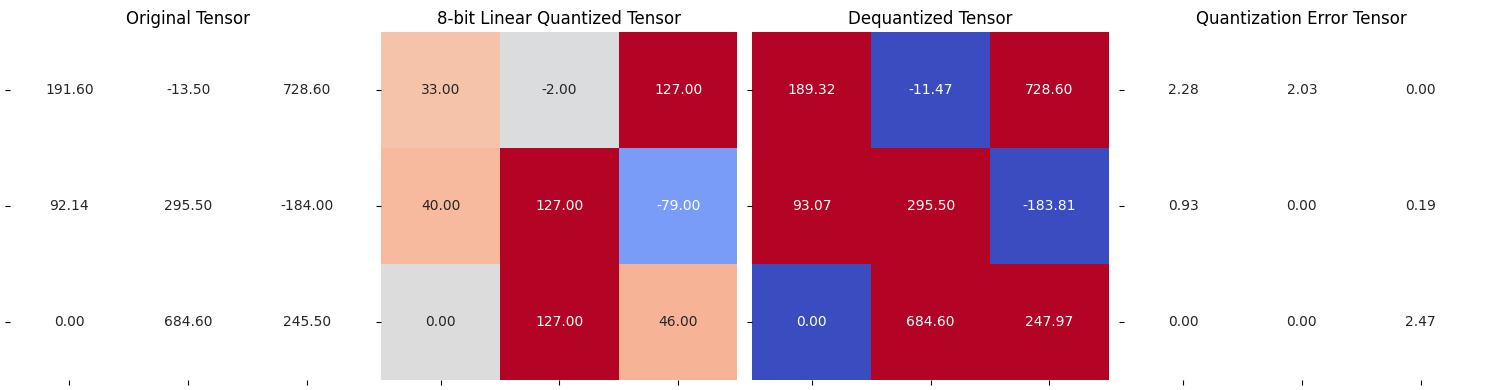

In [37]:
# 按行

# 反量化
dequantized_tensor_0 = linear_dequantization(
    quantized_tensor_0, scale_0, 0)

# 可视化量化误差
plot_quantization_errors(
    test_tensor, quantized_tensor_0, dequantized_tensor_0)

In [38]:
# 总体量化误差
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_0)}""")

Quantization Error : 1.8084441423416138


- Plot the quantization error for along the columns.

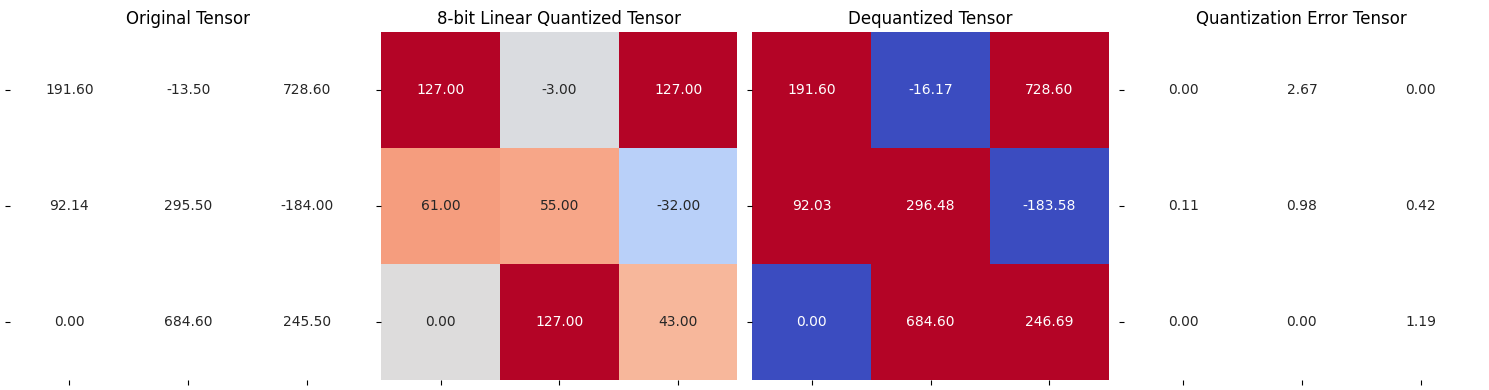

Quantization Error : 1.0781488418579102


In [39]:
# 按列

# 反量化
dequantized_tensor_1 = linear_dequantization(
    quantized_tensor_1, scale_1, 0)

# 可视化量化误差
plot_quantization_errors(
    test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)

# 总体量化误差
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")